In [3]:
import os
import numpy as np
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sympy.codegen.cfunctions import log10
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import time
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [4]:
import torch

torch.cuda.empty_cache()


In [5]:
import torch
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())

11.8
90100
True


In [6]:
if torch.cuda.is_available():
    print(f"GPU kullanılabilir. Cihaz: {torch.cuda.get_device_name(0)}")
else:
    print("GPU kullanılabilir değil, CPU kullanılacak.")

GPU kullanılabilir. Cihaz: NVIDIA GeForce GTX 1650 Ti


In [6]:
for dirname, _, filenames in os.walk('kıyafet'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kıyafet\labels.csv
kıyafet\IMAGES\img_0001.png
kıyafet\IMAGES\img_0002.png
kıyafet\IMAGES\img_0003.png
kıyafet\IMAGES\img_0004.png
kıyafet\IMAGES\img_0005.png
kıyafet\IMAGES\img_0006.png
kıyafet\IMAGES\img_0007.png
kıyafet\IMAGES\img_0008.png
kıyafet\IMAGES\img_0009.png
kıyafet\IMAGES\img_0010.png
kıyafet\IMAGES\img_0011.png
kıyafet\IMAGES\img_0012.png
kıyafet\IMAGES\img_0013.png
kıyafet\IMAGES\img_0014.png
kıyafet\IMAGES\img_0015.png
kıyafet\IMAGES\img_0016.png
kıyafet\IMAGES\img_0017.png
kıyafet\IMAGES\img_0018.png
kıyafet\IMAGES\img_0019.png
kıyafet\IMAGES\img_0020.png
kıyafet\IMAGES\img_0021.png
kıyafet\IMAGES\img_0022.png
kıyafet\IMAGES\img_0023.png
kıyafet\IMAGES\img_0024.png
kıyafet\IMAGES\img_0025.png
kıyafet\IMAGES\img_0026.png
kıyafet\IMAGES\img_0027.png
kıyafet\IMAGES\img_0028.png
kıyafet\IMAGES\img_0029.png
kıyafet\IMAGES\img_0030.png
kıyafet\IMAGES\img_0031.png
kıyafet\IMAGES\img_0032.png
kıyafet\IMAGES\img_0034.png
kıyafet\IMAGES\img_0035.png
kıyafet\IMAGES\img_0036.png
k

In [7]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.2):
        super().__init__()

        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batchN2 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()

        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.dropout = nn.Dropout2d(p=dropout_rate)  # Dropout2d tercih edilir

    def forward(self, x: torch.Tensor):
        x = self.first(x)
        x = self.batchN2(x)
        x = self.act1(x)
        x = self.dropout(x)  # Dropout burada çalışır
        x = self.second(x)
        return self.act2(x)


In [8]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x:torch.Tensor):
        return self.pool(x)

In [9]:
class UpSample(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x:torch.Tensor):
        return self.up(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.down_conv = nn.ModuleList([
            DoubleConvolution(in_channels, 64),
            DoubleConvolution(64, 128),
            DoubleConvolution(128, 256),
        ])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(3)])

        self.mid_conv = DoubleConvolution(256, 512)

        self.up_sample = nn.ModuleList([
            UpSample(512, 256),
            UpSample(256, 128),
            UpSample(128, 64),
        ])
        self.up_conv = nn.ModuleList([
            DoubleConvolution(512, 256),
            DoubleConvolution(256, 128),
            DoubleConvolution(128, 64),
        ])

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        skip_connections = []

        for down, pool in zip(self.down_conv, self.down_sample):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)

        x = self.mid_conv(x)
        skip_connections = skip_connections[::-1]

        for idx in range(len(self.up_sample)):
            x = self.up_sample[idx](x)
            skip = skip_connections[idx]

            if x.shape != skip.shape:
                diffY = skip.size(2) - x.size(2)
                diffX = skip.size(3) - x.size(3)
                skip = skip[:, :, diffY // 2: diffY // 2 + x.size(2), diffX // 2: diffX // 2 + x.size(3)]

            x = torch.cat((skip, x), dim=1)
            x = self.up_conv[idx](x)

        x = self.final_conv(x)
        return x


In [11]:
class ClothingSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # ✅ NumPy array olarak dönüştür
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        mask = mask.long()
        return image, mask

In [12]:
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.Sharpen(p=0.5),
        A.Emboss(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ], p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # ✅ Zorunlu
    ToTensorV2()
])

In [13]:
image_dir = "kıyafet/IMAGES"
mask_dir = "kıyafet/MASKS"

dataset = ClothingSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=transform
)

In [14]:
test_size = int(0.1 * len(dataset))
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size
xtrain, xval, xtest = random_split(dataset, [train_size, val_size, test_size])

In [15]:
train_loader = DataLoader(xtrain, batch_size=16, shuffle=True)
val_loader = DataLoader(xval, batch_size=16, shuffle=False)
test_loader = DataLoader(xtest, batch_size=16, shuffle=False)

In [16]:
label_path = "kıyafet/labels.csv"
labels = pd.read_csv(label_path)

Image example: ['img_0001.png', 'img_0002.png', 'img_0003.png', 'img_0004.png', 'img_0005.png']
Mask example: ['seg_0001.png', 'seg_0002.png', 'seg_0003.png', 'seg_0004.png', 'seg_0005.png']


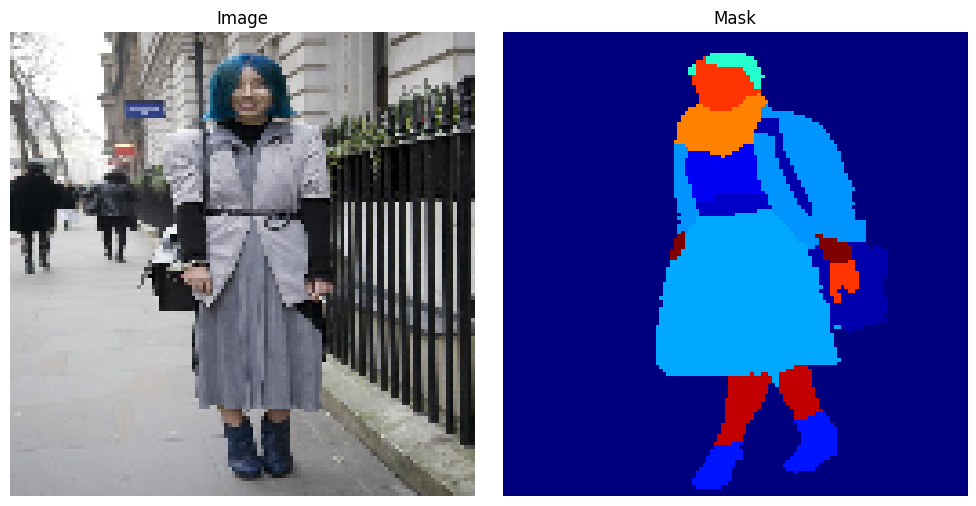

In [20]:
print("Image example:", dataset.image_filenames[:5])
print("Mask example:", dataset.mask_filenames[:5])

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_iter = iter(train_loader)
images, masks = next(train_iter)

img_idx = 0
image = images[img_idx].clone()
mask = masks[img_idx]

# Geri normalize et
image = unnormalize(image, mean, std)

# PIL formatına çevir
image = TF.to_pil_image(image)

# Görselleştir
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(mask.numpy(), cmap="jet")
ax[1].set_title("Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
def edge_loss(pred, target, edge_weight=1.0):
    # Sobel filtreleri
    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=pred.device).unsqueeze(0).unsqueeze(0)

    sobel_y = torch.tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float32, device=pred.device).unsqueeze(0).unsqueeze(0)

    # Tahmin edilen kenar haritası
    pred_soft = F.softmax(pred, dim=1)
    pred_edges = torch.abs(F.conv2d(pred_soft[:, 1:2], sobel_x, padding=1)) + \
                 torch.abs(F.conv2d(pred_soft[:, 1:2], sobel_y, padding=1))

    # Gerçek maskeyi one-hot yap ve kenarları al
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    target_edges = torch.abs(F.conv2d(target_onehot[:, 1:2], sobel_x, padding=1)) + \
                   torch.abs(F.conv2d(target_onehot[:, 1:2], sobel_y, padding=1))

    # Kenar farkları
    return F.l1_loss(pred_edges, target_edges) * edge_weight


def dice_loss(pred, target, smooth=1e-3):
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


def total_segmentation_loss(outputs, masks, weight_ce=1.0, weight_dice=1.0, weight_edge=0.6):
    # Cross Entropy Loss
    ce = F.cross_entropy(outputs, masks)

    # Dice için hazırlık
    masks_onehot = F.one_hot(masks, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
    probs = F.softmax(outputs, dim=1)
    d_loss = dice_loss(probs, masks_onehot)

    # Edge-aware loss
    e_loss = edge_loss(outputs, masks, edge_weight=1.0)

    # Toplam
    total = weight_ce * ce + weight_dice * d_loss + weight_edge * e_loss
    return total


In [22]:
model = UNet(3, 59)


In [23]:
criterion = total_segmentation_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to (device)

UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
      (dropout): Dropout2d(p=0.2, inplace=False)
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
      (dropout): Dropout2d(p=0.2, inplace=False)
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
##model save
save_pth = r"models"
model_files = [f for f in os.listdir(save_pth) if f.startswith("unet_model") and f.endswith("pth")]
if not model_files:
    model_filename = "unet_model_1.pth"
else:
    model_max_suffix = max([int(f.split('_')[-1].split('.')[0]) for f in model_files])
    model_filename = f"unet_model_{model_max_suffix + 1}.pth"

##graph save
graphics_pth = r"graphics"
if not os.path.exists(graphics_pth):
    os.makedirs(graphics_pth)
graphic_files = [f for f in os.listdir(graphics_pth) if f.startswith("graph") and f.endswith("png")]
if not graphic_files:
    graphic_filename = "graph_1.png"
else:
    graphic_max_suffix = max([int(f.split('_')[-1].split('.')[0]) for f in graphic_files])
    graphic_filename = f"graph_{graphic_max_suffix + 1}.png"
graphic_save_path = os.path.join(graphics_pth, graphic_filename)

In [129]:
log_pth = r"logs"
log_files = [f for f in os.listdir(log_pth) if f.startswith("log") and f.endswith("csv")]
if not log_files:
    log_filename = "log_1.csv"
else:
    log_max_suffix = max([int(f.split('_')[-1].split('.')[0]) for f in log_files])
    log_filename = f"log_{log_max_suffix + 1}.csv"
log_save_path = os.path.join(log_pth, log_filename)


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_accuracy = 0.0
best_epoch = 0
best_model_weights = None

with open(log_save_path, 'w') as csvfile:
    csvfile.write(f'Best Validation Accuracy:\t\n')
    csvfile.write(f'Test Accuracy:\t\n')
    csvfile.write(f'Inference Speed:\t\n')
    csvfile.write(f'Epoch\tloss_t\taccuracy_t\tloss_v\taccuracy_v\n')

print("Start Training...")

num_epochs = 80

for epoch in range(num_epochs):
    
    print(f"Epoch {epoch + 1}")

    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []


    for images, masks in tqdm(train_loader, desc=f"Training"):
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()

        outputs = model(images)
        loss = criterion(outputs, masks, weight_ce=1.0, weight_dice=1.0, weight_edge=0.6)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)  # <--- DÜZELTİLEN KISIM
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(masks.cpu().numpy())
    
    # Train accuracy hesapla
    train_acc = accuracy_score(
        np.array(train_labels).flatten(),
        np.array(train_preds).flatten()
    )
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    ### -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validation"):
            images = images.to(device)
            masks = masks.to(device)

            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(masks.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    
    val_accuracy = accuracy_score(
        np.array(val_labels).flatten(),
        np.array(val_preds).flatten()
    )

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    ### -------- LOG FILE --------
    with open(log_save_path, 'a') as csvfile:
        csvfile.write(f"{epoch + 1}\t{avg_train_loss:.4f}\t{train_acc:.4f}\t{avg_val_loss:.4f}\t{val_accuracy:.4f}\n")

    ### -------- BEST MODEL KAYDET --------
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1
        best_model_weights = model.state_dict()

# Eğitim sonrası en iyi modeli kaydet
if best_model_weights is not None:
    model_save_path = os.path.join(save_pth, model_filename)
    torch.save(best_model_weights, model_save_path)
    print(f"\n✅ Best model saved at epoch {best_epoch} with {best_accuracy:.2f} val accuracy.")
    
    
print("finished training")

##loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(graphic_save_path, format='png')
plt.close()
##accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig(graphic_save_path, format='png')
plt.close()

Start Training...
Epoch 1


Training: 100%|██████████| 44/44 [00:22<00:00,  1.94it/s]


Train Loss: 2.3909, Train Accuracy: 0.7478


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Val Loss: 1.9639, Val Accuracy: 0.7696
Epoch 2


Training: 100%|██████████| 44/44 [00:22<00:00,  1.97it/s]


Train Loss: 1.8992, Train Accuracy: 0.7727


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Val Loss: 1.8758, Val Accuracy: 0.7801
Epoch 3


Training: 100%|██████████| 44/44 [00:22<00:00,  1.93it/s]


Train Loss: 1.8454, Train Accuracy: 0.7832


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Val Loss: 1.8461, Val Accuracy: 0.7857
Epoch 4


Training: 100%|██████████| 44/44 [00:22<00:00,  1.91it/s]


Train Loss: 1.8041, Train Accuracy: 0.7884


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Val Loss: 1.8007, Val Accuracy: 0.7932
Epoch 5


Training: 100%|██████████| 44/44 [00:23<00:00,  1.88it/s]


Train Loss: 1.7680, Train Accuracy: 0.7930


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Val Loss: 1.8177, Val Accuracy: 0.7890
Epoch 6


Training: 100%|██████████| 44/44 [00:23<00:00,  1.86it/s]


Train Loss: 1.7260, Train Accuracy: 0.8018


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Val Loss: 1.6791, Val Accuracy: 0.8032
Epoch 7


Training: 100%|██████████| 44/44 [00:23<00:00,  1.85it/s]


Train Loss: 1.4792, Train Accuracy: 0.8024


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Val Loss: 1.4032, Val Accuracy: 0.8040
Epoch 8


Training: 100%|██████████| 44/44 [00:24<00:00,  1.82it/s]


Train Loss: 1.3423, Train Accuracy: 0.8054


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Val Loss: 1.3237, Val Accuracy: 0.8134
Epoch 9


Training: 100%|██████████| 44/44 [00:23<00:00,  1.83it/s]


Train Loss: 1.3225, Train Accuracy: 0.8105


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Val Loss: 1.3175, Val Accuracy: 0.8124
Epoch 10


Training: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s]


Train Loss: 1.2968, Train Accuracy: 0.8145


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Val Loss: 1.3636, Val Accuracy: 0.8082
Epoch 11


Training: 100%|██████████| 44/44 [00:24<00:00,  1.82it/s]


Train Loss: 1.2759, Train Accuracy: 0.8183


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Val Loss: 1.2799, Val Accuracy: 0.8167
Epoch 12


Training: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s]


Train Loss: 1.2554, Train Accuracy: 0.8217


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Val Loss: 1.2538, Val Accuracy: 0.8225
Epoch 13


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.2379, Train Accuracy: 0.8253


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Val Loss: 1.2513, Val Accuracy: 0.8218
Epoch 14


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.2275, Train Accuracy: 0.8264


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Val Loss: 1.2865, Val Accuracy: 0.8243
Epoch 15


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.2116, Train Accuracy: 0.8300


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Val Loss: 1.2288, Val Accuracy: 0.8280
Epoch 16


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.1948, Train Accuracy: 0.8348


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Val Loss: 1.2146, Val Accuracy: 0.8309
Epoch 17


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.1865, Train Accuracy: 0.8362


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Val Loss: 1.2047, Val Accuracy: 0.8347
Epoch 18


Training: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


Train Loss: 1.1742, Train Accuracy: 0.8388


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Val Loss: 1.1996, Val Accuracy: 0.8304
Epoch 19


Training: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


Train Loss: 1.1758, Train Accuracy: 0.8376


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Val Loss: 1.1870, Val Accuracy: 0.8401
Epoch 20


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.1597, Train Accuracy: 0.8415


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Val Loss: 1.1844, Val Accuracy: 0.8372
Epoch 21


Training: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


Train Loss: 1.1552, Train Accuracy: 0.8428


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Val Loss: 1.2048, Val Accuracy: 0.8307
Epoch 22


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.1558, Train Accuracy: 0.8432


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Val Loss: 1.1741, Val Accuracy: 0.8381
Epoch 23


Training: 100%|██████████| 44/44 [00:25<00:00,  1.72it/s]


Train Loss: 1.1377, Train Accuracy: 0.8458


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Val Loss: 1.1724, Val Accuracy: 0.8395
Epoch 24


Training: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Train Loss: 1.1356, Train Accuracy: 0.8453


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Val Loss: 1.1496, Val Accuracy: 0.8405
Epoch 25


Training: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


Train Loss: 1.1232, Train Accuracy: 0.8487


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Val Loss: 1.1513, Val Accuracy: 0.8452
Epoch 26


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.1128, Train Accuracy: 0.8519


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Val Loss: 1.1671, Val Accuracy: 0.8390
Epoch 27


Training: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


Train Loss: 1.1111, Train Accuracy: 0.8528


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Val Loss: 1.1405, Val Accuracy: 0.8413
Epoch 28


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.1000, Train Accuracy: 0.8540


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Val Loss: 1.1307, Val Accuracy: 0.8482
Epoch 29


Training: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Train Loss: 1.1013, Train Accuracy: 0.8550


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Val Loss: 1.1373, Val Accuracy: 0.8442
Epoch 30


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.0940, Train Accuracy: 0.8557


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Val Loss: 1.1374, Val Accuracy: 0.8475
Epoch 31


Training: 100%|██████████| 44/44 [00:24<00:00,  1.76it/s]


Train Loss: 1.0889, Train Accuracy: 0.8567


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Val Loss: 1.1198, Val Accuracy: 0.8481
Epoch 32


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.0820, Train Accuracy: 0.8576


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Val Loss: 1.1357, Val Accuracy: 0.8487
Epoch 33


Training: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Train Loss: 1.0783, Train Accuracy: 0.8588


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Val Loss: 1.1289, Val Accuracy: 0.8475
Epoch 34


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.0714, Train Accuracy: 0.8619


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Val Loss: 1.1090, Val Accuracy: 0.8512
Epoch 35


Training: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


Train Loss: 1.0632, Train Accuracy: 0.8632


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Val Loss: 1.1315, Val Accuracy: 0.8498
Epoch 36


Training: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Train Loss: 1.0560, Train Accuracy: 0.8643


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Val Loss: 1.1265, Val Accuracy: 0.8514
Epoch 37


Training: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Train Loss: 1.0521, Train Accuracy: 0.8653


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Val Loss: 1.1236, Val Accuracy: 0.8524
Epoch 38


Training: 100%|██████████| 44/44 [00:33<00:00,  1.30it/s]


Train Loss: 1.0537, Train Accuracy: 0.8648


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Val Loss: 1.1616, Val Accuracy: 0.8478
Epoch 39


Training: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


Train Loss: 1.0530, Train Accuracy: 0.8647


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Val Loss: 1.1108, Val Accuracy: 0.8568
Epoch 40


Training: 100%|██████████| 44/44 [00:32<00:00,  1.37it/s]


Train Loss: 1.0351, Train Accuracy: 0.8683


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Val Loss: 1.1125, Val Accuracy: 0.8545
Epoch 41


Training: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


Train Loss: 1.0339, Train Accuracy: 0.8700


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Val Loss: 1.1235, Val Accuracy: 0.8538
Epoch 42


Training: 100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Train Loss: 1.0298, Train Accuracy: 0.8715


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Val Loss: 1.1150, Val Accuracy: 0.8533
Epoch 43


Training: 100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Train Loss: 1.0239, Train Accuracy: 0.8728


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Val Loss: 1.1256, Val Accuracy: 0.8513
Epoch 44


Training: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]


Train Loss: 1.0244, Train Accuracy: 0.8718


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Loss: 1.1088, Val Accuracy: 0.8551
Epoch 45


Training: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]


Train Loss: 1.0122, Train Accuracy: 0.8732


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Val Loss: 1.0977, Val Accuracy: 0.8578
Epoch 46


Training: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Train Loss: 1.0006, Train Accuracy: 0.8780


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Val Loss: 1.1172, Val Accuracy: 0.8522
Epoch 47


Training: 100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Train Loss: 1.0079, Train Accuracy: 0.8766


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Val Loss: 1.1021, Val Accuracy: 0.8574
Epoch 48


Training: 100%|██████████| 44/44 [00:32<00:00,  1.34it/s]


Train Loss: 1.0051, Train Accuracy: 0.8779


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Val Loss: 1.1055, Val Accuracy: 0.8551
Epoch 49


Training: 100%|██████████| 44/44 [00:29<00:00,  1.51it/s]


Train Loss: 0.9843, Train Accuracy: 0.8810


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Val Loss: 1.1127, Val Accuracy: 0.8580
Epoch 50


Training: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Train Loss: 0.9811, Train Accuracy: 0.8814


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Val Loss: 1.1231, Val Accuracy: 0.8557
Epoch 51


Training: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Train Loss: 0.9748, Train Accuracy: 0.8841


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Val Loss: 1.1203, Val Accuracy: 0.8570
Epoch 52


Training: 100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Train Loss: 0.9783, Train Accuracy: 0.8824


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Loss: 1.1006, Val Accuracy: 0.8587
Epoch 53


Training: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]


Train Loss: 0.9704, Train Accuracy: 0.8844


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Val Loss: 1.1475, Val Accuracy: 0.8565
Epoch 54


Training: 100%|██████████| 44/44 [00:32<00:00,  1.37it/s]


Train Loss: 0.9633, Train Accuracy: 0.8868


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Val Loss: 1.1060, Val Accuracy: 0.8583
Epoch 55


Training: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Train Loss: 0.9641, Train Accuracy: 0.8863


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Val Loss: 1.1132, Val Accuracy: 0.8587
Epoch 56


Training: 100%|██████████| 44/44 [00:33<00:00,  1.33it/s]


Train Loss: 0.9596, Train Accuracy: 0.8873


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Val Loss: 1.1223, Val Accuracy: 0.8569
Epoch 57


Training: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Train Loss: 0.9542, Train Accuracy: 0.8883


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Val Loss: 1.1129, Val Accuracy: 0.8585
Epoch 58


Training: 100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Train Loss: 0.9461, Train Accuracy: 0.8907


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Val Loss: 1.1000, Val Accuracy: 0.8597
Epoch 59


Training: 100%|██████████| 44/44 [00:32<00:00,  1.36it/s]


Train Loss: 0.9457, Train Accuracy: 0.8909


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Val Loss: 1.1179, Val Accuracy: 0.8591
Epoch 60


Training: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Train Loss: 0.9410, Train Accuracy: 0.8938


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Val Loss: 1.1251, Val Accuracy: 0.8586
Epoch 61


Training: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Train Loss: 0.9350, Train Accuracy: 0.8940


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Val Loss: 1.1247, Val Accuracy: 0.8604
Epoch 62


Training: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Train Loss: 0.9297, Train Accuracy: 0.8955


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Val Loss: 1.1029, Val Accuracy: 0.8593
Epoch 63


Training: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Train Loss: 0.9240, Train Accuracy: 0.8962


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Val Loss: 1.1181, Val Accuracy: 0.8609
Epoch 64


Training: 100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Train Loss: 0.9179, Train Accuracy: 0.8982


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Loss: 1.1214, Val Accuracy: 0.8604
Epoch 65


Training: 100%|██████████| 44/44 [00:32<00:00,  1.35it/s]


Train Loss: 0.9175, Train Accuracy: 0.9001


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val Loss: 1.1398, Val Accuracy: 0.8576
Epoch 66


Training: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]


Train Loss: 0.9075, Train Accuracy: 0.9008


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Val Loss: 1.1563, Val Accuracy: 0.8625
Epoch 67


Training: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]


Train Loss: 0.9073, Train Accuracy: 0.9011


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Val Loss: 1.1469, Val Accuracy: 0.8561
Epoch 68


Training: 100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


Train Loss: 0.9060, Train Accuracy: 0.9010


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Val Loss: 1.1469, Val Accuracy: 0.8593
Epoch 69


Training: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]


Train Loss: 0.9014, Train Accuracy: 0.9026


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Val Loss: 1.1351, Val Accuracy: 0.8590
Epoch 70


Training: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]


Train Loss: 0.8956, Train Accuracy: 0.9039


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Val Loss: 1.1300, Val Accuracy: 0.8604
Epoch 71


Training: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


Train Loss: 0.8865, Train Accuracy: 0.9055


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Val Loss: 1.1489, Val Accuracy: 0.8568
Epoch 72


Training: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Train Loss: 0.8835, Train Accuracy: 0.9065


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Loss: 1.1588, Val Accuracy: 0.8596
Epoch 73


Training: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]


Train Loss: 0.8735, Train Accuracy: 0.9092


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Val Loss: 1.1636, Val Accuracy: 0.8615
Epoch 74


Training: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]


Train Loss: 0.8862, Train Accuracy: 0.9056


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Val Loss: 1.1574, Val Accuracy: 0.8582
Epoch 75


Training: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Train Loss: 0.8715, Train Accuracy: 0.9089


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Val Loss: 1.1669, Val Accuracy: 0.8602
Epoch 76


Training: 100%|██████████| 44/44 [00:32<00:00,  1.36it/s]


Train Loss: 0.8688, Train Accuracy: 0.9109


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Val Loss: 1.1485, Val Accuracy: 0.8592
Epoch 77


Training: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]


Train Loss: 0.8686, Train Accuracy: 0.9104


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Val Loss: 1.1571, Val Accuracy: 0.8590
Epoch 78


Training: 100%|██████████| 44/44 [00:32<00:00,  1.33it/s]


Train Loss: 0.8713, Train Accuracy: 0.9104


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Val Loss: 1.2243, Val Accuracy: 0.8590
Epoch 79


Training: 100%|██████████| 44/44 [01:38<00:00,  2.24s/it]


Train Loss: 0.8644, Train Accuracy: 0.9123


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Val Loss: 1.1591, Val Accuracy: 0.8605
Epoch 80


Training: 100%|██████████| 44/44 [00:21<00:00,  2.08it/s]


Train Loss: 0.8568, Train Accuracy: 0.9125


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Val Loss: 1.1772, Val Accuracy: 0.8584

✅ Best model saved at epoch 66 with 0.86 val accuracy.
finished training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


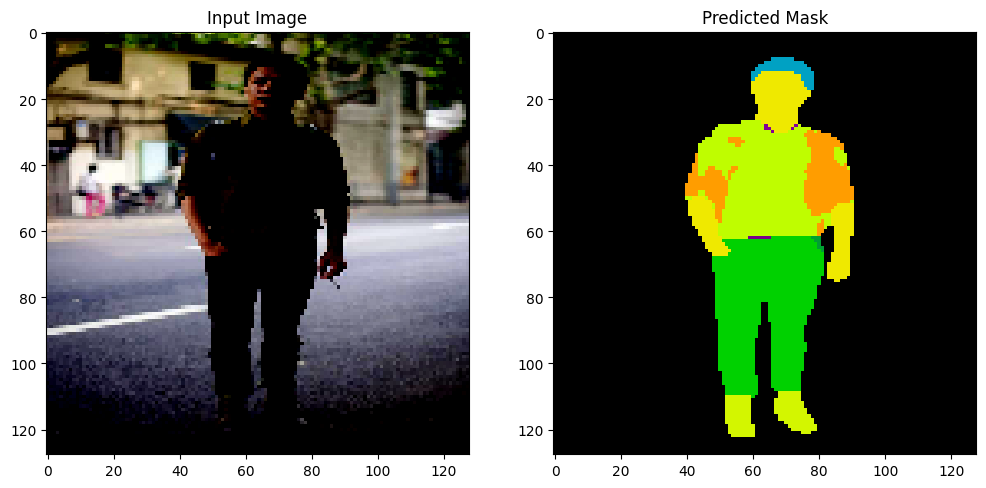

Test Accuracy: 0.90%
Inference Speed: 11.33 samples/sec


In [130]:

model=UNet(3,59)
device = torch.device("cpu")
model.to(device)
## model load
model.load_state_dict(torch.load(os.path.join(save_pth, "unet_model_20.pth"),weights_only=True))
model.eval()

conf_pth =r"graphics"
conf_files = [s for s in os.listdir(conf_pth) if s.startswith("unet_conf")and s.endswith("png")]
if not conf_files:
    conf_filename = "unet_conf_1.png"
else:
    conf_max_suffix = max([int(s.split('_')[-1].split('.')[0]) for s in conf_files])
    conf_filename = f"unet_conf_{conf_max_suffix + 1}.png"
conf_save_path = os.path.join(conf_pth, conf_filename)


total_pixels = 0
correct_pixels = 0
inference_times = []

with torch.no_grad():
    for idx, (image, mask) in enumerate(test_loader):
        image = image.to(device)
        mask = mask.to(device)

        start_time = time.time()
        output = model(image)
        end_time = time.time()

        inference_time = end_time - start_time
        inference_times.append(inference_time)

        pred = torch.argmax(output, dim=1)  # shape: [1, H, W]

        # Accuracy
        correct = (pred == mask).sum().item()
        total = torch.numel(mask)

        correct_pixels += correct
        total_pixels += total

        if idx == 0:
            img_np = image[0].cpu()
            if img_np.shape[0] == 3:
                img_np = img_np.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
            mask_np = pred[0].cpu().numpy()

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img_np.numpy())
            plt.title("Input Image")

            plt.subplot(1, 2, 2)
            plt.imshow(mask_np, cmap="nipy_spectral", vmin=0, vmax=58)
            plt.title("Predicted Mask")
            plt.show()


test_accuracy = correct_pixels / total_pixels

inference_start_time = time.time()
with torch.no_grad():
    for inputs, _ in test_loader:
        _ = model(inputs)
inference_end_time = time.time()

num_samples = len(test_loader.dataset)
inference_speed = num_samples / (inference_end_time - inference_start_time)

with open("logs/log_25.csv", 'r') as csvfile:
    lines = csvfile.readlines()

lines[0] = f'Best Validation Accuracy:\t{best_accuracy:.2f}% at Epoch {best_epoch}\n'
lines[1] = f'Test Accuracy:\t{test_accuracy:.2f}%\n'
lines[2] = f'Inference Speed:\t{inference_speed:.2f} samples/sec\n'

with open("logs/log_25.csv", 'w') as csvfile:
    csvfile.writelines(lines)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Inference Speed: {inference_speed:.2f} samples/sec")

import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import mediapipe as mp
from model import UNet
# ------------------------
# Mediapipe POSE Tahmin
# ------------------------

def visualize_keypoints(image, keypoints, point_names=None):
    image_copy = image.copy()
    important_indices = [11, 12, 23, 24]  # LS, RS, LH, RH    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
    names = ['LS', 'RS', 'LH', 'RH'] if point_names is None else point_names

    for idx, color, name in zip(important_indices, colors, names):
        x, y = int(keypoints[idx][0]), int(keypoints[idx][1])
        cv2.circle(image_copy, (x, y), 8, color, -1)
        cv2.putText(image_copy, name, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return image_copy

class PoseEstimator:
    def __init__(self):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(static_image_mode=True)
        self.mp_drawing = mp.solutions.drawing_utils

    def get_keypoints(self, image):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)
        if not results.pose_landmarks:
            return None
        h, w, _ = image.shape
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.append([int(lm.x * w), int(lm.y * h), lm.visibility])
        return np.array(keypoints)

    def draw_pose(self, image, landmarks=None):
        if landmarks is None:
            landmarks = self.pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).pose_landmarks
        if landmarks:
            self.mp_drawing.draw_landmarks(image, landmarks, self.mp_pose.POSE_CONNECTIONS)
        return image

# ------------------------
# Yardımcı Fonksiyonlar
# ------------------------

def segment_cloth(image_pil, model, device):
    image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image, (256, 256))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_tensor = torch.from_numpy(image_rgb).permute(2, 0, 1).float() / 255.0
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)  # [1, 59, H, W]
        mask = torch.argmax(output[0], dim=0).cpu().numpy()

    unique, counts = np.unique(mask, return_counts=True)
    class_freq = dict(zip(unique, counts))
    class_freq.pop(0, None)

    if not class_freq:
        dominant_class = 0
    else:
        dominant_class = max(class_freq, key=class_freq.get)

    print("Seçilen dominant sınıf:", dominant_class)


    binary_mask = np.where(mask == dominant_class, 255, 0).astype(np.uint8)

    # Maske düzeltme
    kernel = np.ones((5, 5), np.uint8)
    mask_dilated = cv2.dilate(binary_mask, kernel, iterations=5)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_dilated, connectivity=8)
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask_clean = np.where(labels == largest_component, 255, 0).astype(np.uint8)

    return mask_clean

# ------------------------
# Warping Fonksiyonu
# ------------------------
def overlay(person_img, warped_clothes, warped_mask):
    if warped_mask.ndim == 3:
        warped_mask = cv2.cvtColor(warped_mask, cv2.COLOR_BGR2GRAY)

    mask_bin = (warped_mask > 0).astype(np.uint8) * 255
    inv_mask = cv2.bitwise_not(mask_bin)

    person_part = cv2.bitwise_and(person_img, person_img, mask=inv_mask)
    clothes_part = cv2.bitwise_and(warped_clothes, warped_clothes, mask=mask_bin)

    result = cv2.add(person_part, clothes_part)


    return result


def warp_clothes_perspective(clothes_img, mask, keypoints, person_img, widen_ratio=0.5):
    # Omuz ve kalça noktaları
    LS = np.array(keypoints[11][:2], dtype=np.float32)
    RS = np.array(keypoints[12][:2], dtype=np.float32)
    LH = np.array(keypoints[23][:2], dtype=np.float32)
    RH = np.array(keypoints[24][:2], dtype=np.float32)

    # Omuzlar arası vektör ve genişletme
    shoulder_vec = RS - LS
    hip_vec = RH - LH

    # Vektörün normu kadar orantılı dışa kaydır
    shoulder_extend = shoulder_vec * widen_ratio
    hip_extend = hip_vec * widen_ratio

    # Genişletilmiş hedef noktalar
    LS_wide = LS - shoulder_extend
    RS_wide = RS + shoulder_extend
    LH_wide = LH - hip_extend
    RH_wide = RH + hip_extend

    dst_pts = np.array([LS_wide, RS_wide, RH_wide, LH_wide], dtype=np.float32)

    # Maske bounding box 4 köşesi (kaynak noktalar)
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        print("⚠️ Maske boş olabilir.")
        return person_img
    x, y, w, h = cv2.boundingRect(np.stack([xs, ys], axis=1))
    src_pts = np.array([
        [x,     y    ],
        [x + w, y    ],
        [x + w, y + h],
        [x,     y + h]
    ], dtype=np.float32)

    # Perspective dönüşüm
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Hp, Wp = person_img.shape[:2]
    warped_clothes = cv2.warpPerspective(clothes_img, M, (Wp, Hp), flags=cv2.INTER_LINEAR)
    warped_mask = cv2.warpPerspective(mask, M, (Wp, Hp), flags=cv2.INTER_NEAREST)
    warped_mask = (warped_mask > 0).astype(np.uint8) * 255

    result = overlay(person_img, warped_clothes, warped_mask)
    return result


model = UNet(3, 59)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("models/unet_model_2.pth",map_location=device))
model.to(device)
model.eval()
pose_estimator = PoseEstimator()

source_image_path = "tişört2.jpg"       # Kıyafet resmi
target_image_path = "denenecek.jpg"   # Kişi resmi

# Kıyafet resmi
source_pil = Image.open(source_image_path).convert("RGB")
mask = segment_cloth(source_pil, model, device)

source_np = cv2.resize(np.array(source_pil), (256, 256))  # RGB formatta geliyor
source_np = cv2.cvtColor(source_np, cv2.COLOR_RGB2BGR)     # BGR çevir
mask = cv2.resize(mask, (256, 256))                        # Maskeyi eşle
clothing = cv2.bitwise_and(source_np, source_np, mask=mask)

# Kişi resmi
target_pil = Image.open(target_image_path).convert("RGB")
target_np = np.array(target_pil)
target_np = cv2.cvtColor(target_np, cv2.COLOR_RGB2BGR)

# 🔍 Keypoint çıkarımı
keypoints = pose_estimator.get_keypoints(target_np)

# (Opsiyonel) Anahtar noktaları görselleştir
target_with_points = visualize_keypoints(target_np.copy(), keypoints)

# 👕 Giydirme işlemi
if keypoints is not None:
    giydirilmis = warp_clothes_perspective(clothing, mask, keypoints, target_np)
else:
    print("⚠️ Anahtar noktalar alınamadı, varsayılan giydirme yapılacak.")
    alpha = mask.astype(float) / 255.0
    alpha = np.stack([alpha]*3, axis=-1)
    giydirilmis = (alpha * clothing + (1 - alpha) * target_np).astype(np.uint8)

# ------------------------
# Gösterim
# ------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 4, 1)
plt.title("Kaynak (Kıyafet)")
plt.imshow(cv2.cvtColor(source_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Hedef (Kişi)")
plt.imshow(cv2.cvtColor(target_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Anahtar Noktalar")
plt.imshow(cv2.cvtColor(target_with_points, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Giydirilmiş")
plt.imshow(cv2.cvtColor(giydirilmis, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import torch
from posetespiti import PoseEstimator
from segmentasyon import load_model, segment_cloth
from kıyafetigiydir import warp_clothes, overlay

def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def run_virtual_tryon_auto(person_img_path, clothes_img_path, unet_model_path,output_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Görselleri oku
    person_img = cv2.imread(person_img_path)
    clothes_img = cv2.imread(clothes_img_path)

    if person_img is None or clothes_img is None:
        raise ValueError("Görseller yüklenemedi. Dosya yolları doğru mu?")

    # Segmentasyon modeli yükle
    unet_model = load_model(unet_model_path, device)
    binary_mask = segment_cloth(clothes_img, unet_model, device)
    segmented_clothes = apply_mask(clothes_img, binary_mask)

    # Poz tahmini
    pose_estimator = PoseEstimator()
    keypoints = pose_estimator.get_keypoints(person_img)

    # Giydirme işlemi
    if keypoints is not None:
        try:
            warped_clothes, warped_mask = warp_clothes(
                segmented_clothes,
                binary_mask,
                keypoints,
                person_img,
                widen_ratio=0.3  # isteğe bağlı
            )
            result = overlay(person_img, warped_clothes, warped_mask)
        except Exception as e:
            print("⚠️ Warp sırasında hata:", e)
            result = blended_fallback(person_img, segmented_clothes, binary_mask)
            
    else:
        print("⚠️ Anahtar noktalar bulunamadı. Fallback blending uygulanıyor.")
        result = blended_fallback(person_img, segmented_clothes, binary_mask)

    return result

def blended_fallback(person_img, clothing_img, mask):
    alpha = mask.astype(float) / 255.0
    alpha = np.stack([alpha] * 3, axis=-1)
    blended = (alpha * clothing_img + (1 - alpha) * person_img).astype(np.uint8)
    return blended
